# Network Analysis of Publications on Studies of Parkinson Disease

In [ ]:
import pandas as pd
import ast
from ast import literal_eval
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
warnings.filterwarnings('ignore')

import sys
import networkx as nx

In [ ]:
def read_data(path, sep):
    df = pd.read_csv(path, sep=sep)
    df.loc[:, 'AA'] = df['AA'].apply(lambda x: ast.literal_eval(x))
    df.loc[:, 'W'] = df['W'].apply(lambda x: ast.literal_eval(x))
    return df

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
data = read_data('filtered_data.csv', sep = ';')

In [ ]:
net = pd.read_csv('excluded_net.csv', sep = ';')

In [ ]:
aff_data = data[['Id', 'AA', 'Y']].copy().rename(columns = {'Y':'Year'})
aff_data.dropna(subset = ['AA'], inplace = True, axis = 0)
aff_data.loc[:, 'AfId'] = aff_data['AA'].apply(lambda x: x[0]['AfId'])
aff_data.loc[:, 'DAfN'] = aff_data['AA'].apply(lambda x: x[0]['DAfN'])

In [ ]:
print('The number of articles without affiliation Id:', len(aff_data[aff_data['AfId'].isna()]))

The number of articles without affiliation Id: 5631


In [ ]:
aff_data

,Id,AA,Year,AfId,DAfN
0,2754967293,"[{'DAuN': 'Valery L Feigin', 'AuN': 'valery l ...",2017,3.985476e+07,Auckland University of Technology
1,2112455323,"[{'DAuN': 'Ronald B. Postuma', 'AuN': 'ronald ...",2015,2.800294e+09,Montreal General Hospital
2,2177834950,"[{'DAuN': 'B. K. Pedersen', 'AuN': 'bente klar...",2015,1.240557e+08,University of Copenhagen
3,2558041282,"[{'DAuN': 'Timothy R. Sampson', 'AuN': 'timoth...",2016,1.224118e+08,California Institute of Technology
4,2901519529,"[{'DAuN': 'E. Ray Dorsey', 'AuN': 'e ray dorse...",2018,5.388228e+06,University of Rochester
...,...,...,...,...,...
39806,2547599175,"[{'DAuN': 'Camilla Louise Barber', 'AuN': 'cam...",2016,NaN,
39807,3112561736,"[{'DAuN': 'Rameeta Kumari', 'AuN': 'rameeta ku...",2020,NaN,
39808,2895767795,"[{'DAuN': 'Teresa de Deus Fonticoba', 'AuN': '...",2019,NaN,"Sección de Neurología, Complexo Hospitalario U..."
39809,2619593042,"[{'DAuN': '叶青', 'AuN': '叶青', 'AuId': 263664462...",2017,NaN,


In [ ]:
aff_data = aff_data[aff_data['AfId'].isna() == False]
aff_data.reset_index(drop = True, inplace = True)

In [ ]:
id_name = aff_data.groupby(['AfId', 'DAfN']).count().reset_index()[['AfId', 'DAfN']].astype(str)
id_name.to_csv('affiliations.csv', sep = ';', index = False)

In [ ]:
id_name = pd.read_csv('affiliations.csv', sep = ';')

## Affiliation network

In [ ]:
aff_net = net.merge(aff_data, left_on = 'ID1', right_on = 'Id', how = 'left')[['ID1', 'ID2', 'Id', 'AfId', 'Y']].rename(columns = {'AfId':'AfId1'})
aff_net = aff_net.merge(aff_data, left_on = 'ID2', right_on = 'Id', how = 'left')[['AfId1', 'AfId', 'Y']].rename(columns = {'AfId':'AfId2'})
aff_net.dropna(subset = ['AfId1', 'AfId2'], inplace = True, axis = 0)

In [ ]:
aff_net = pd.DataFrame(aff_net.groupby(by = ['AfId1', 'AfId2', 'Y']).size()).rename(columns = {0:'weight'}).reset_index()

In [ ]:
aff_net

,AfId1,AfId2,Y,weight
0,4.605000e+03,1.380062e+08,2017,1
1,9.507000e+03,9.507000e+03,2021,1
2,9.507000e+03,3.592860e+07,2021,2
3,9.507000e+03,4.012015e+07,2021,1
4,9.507000e+03,1.776393e+08,2021,1
...,...,...,...,...
170335,3.148998e+09,1.839358e+08,2021,1
170336,3.148998e+09,1.869036e+08,2021,2
170337,3.148998e+09,8.638962e+08,2021,1
170338,3.148998e+09,1.299303e+09,2021,2


In [ ]:
aff_net.to_csv('aff_net.csv', sep = ';', index = False)

In [ ]:
aff_net = pd.read_csv('aff_net.csv', sep = ';')

In [ ]:
print('The number of edges:', aff_net.shape[0])
print('The number of vertices:', len(set(aff_net['AfId1'].values) | set(aff_net['AfId2'].values)))

The number of edges: 170340
The number of vertices: 3029


## Centrality indices

### No periods

In [ ]:
aff_net_no_periods = aff_net.groupby(['AfId1', 'AfId2']).sum()['weight'].reset_index()

In [ ]:
aff_net_no_periods.to_csv('aff_net_no_periods.csv', sep = '\t', index = False, header = False)

In [ ]:
aff_net = pd.read_csv('aff_net_no_periods.csv', sep = '\t', header = None)
aff_net.rename(columns = {0:'AfId1', 1:'AfId2', 2:'weight'}, inplace = True)

In [ ]:
affiliations_info = id_name[id_name['AfId'].isin(set(aff_net['AfId1'].values) | set(aff_net['AfId2'].values))].copy()

weights = aff_net.groupby(['AfId2']).sum()['weight'].reset_index()
affiliations_info = affiliations_info.merge(weights, how = 'left', left_on = 'AfId', right_on = 'AfId2')[['AfId', 'DAfN', 'weight']]
affiliations_info['weight'].fillna(0, inplace = True)

affiliations_info.loc[:, 'In-degree'] = affiliations_info['weight'] / aff_net['weight'].sum()
affiliations_info.loc[:, 'In-degree rank'] = affiliations_info['In-degree'].rank(method = 'dense', ascending = False)

In [ ]:
import sys

import networkx as nx

filenameInput = 'aff_net_no_periods.csv'

Gdirect = nx.read_weighted_edgelist(filenameInput,delimiter='\t',create_using=nx.DiGraph)

print("network loaded" )

print("Pagerank centrality, directed")

prc = nx.pagerank(Gdirect, alpha=0.9, personalization=None, max_iter=100, tol=1e-04, nstart=None, weight='weight', dangling=None)

orig_stdout = sys.stdout

f = open('AffIndices/out_Pagerank.txt', 'w')

sys.stdout = f

for v in Gdirect.nodes():

    print(v,'\t',prc[v])

sys.stdout = orig_stdout

f.close()

prc = pd.DataFrame(prc.items())
prc.rename(columns = {0:'AfId', 1:'PageRank'}, inplace = True)
prc['AfId'] = prc['AfId'].astype(float)
affiliations_info = affiliations_info.merge(prc, how = 'left', on = 'AfId')
affiliations_info.loc[:, 'PageRank rank'] = affiliations_info['PageRank'].rank(method = 'dense', ascending = False)

print("Eigenvector centrality, directed")

eigc = nx.eigenvector_centrality(Gdirect, max_iter=1000, tol=1e-04, nstart=None, weight='weight')

orig_stdout = sys.stdout

f = open('AffIndices/out_Eigen.txt', 'w')

sys.stdout = f

for v in Gdirect.nodes():

    print(v,'\t',eigc[v])

sys.stdout = orig_stdout

f.close()

eigc = pd.DataFrame(eigc.items())
eigc.rename(columns = {0:'AfId', 1:'Eigen'}, inplace = True)
eigc['AfId'] = eigc['AfId'].astype(float)
affiliations_info = affiliations_info.merge(eigc, how = 'left', on = 'AfId')
affiliations_info.loc[:, 'Eigen rank'] = affiliations_info['Eigen'].rank(method = 'dense', ascending = False)


print("Betweenness centrality, directed")

b=nx.algorithms.centrality.betweenness_centrality(Gdirect)

orig_stdout = sys.stdout

f = open('AffIndices/out_Between.txt', 'w')

sys.stdout = f

for v in Gdirect.nodes():

    print(v,'\t',b[v])

sys.stdout = orig_stdout

f.close()

b = pd.DataFrame(b.items())
b.rename(columns = {0:'AfId', 1:'Between'}, inplace = True)
b['AfId'] = b['AfId'].astype(float)
affiliations_info = affiliations_info.merge(b, how = 'left', on = 'AfId')
affiliations_info.loc[:, 'Between rank'] = affiliations_info['Between'].rank(method = 'dense', ascending = False)

print("done ")

network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
done 


In [ ]:
affiliations_info.to_csv('aff_info_classic.csv', sep = ';', index = False)

In [ ]:
affiliations_info = pd.read_csv('aff_info_classic.csv', sep = ';')

In [ ]:
affiliations_info[['AfId', 'In-degree']].to_csv('IndexCI.txt', sep = '\t', index = False)

In [ ]:
# affiliations_info.to_csv('affiliations_info.csv', index = False, sep = ';')

### Periods

In [ ]:
affiliations = pd.read_csv('affiliations.csv', sep = ';')
affiliations_info = pd.read_csv('affiliations_info.csv', sep = ';')

In [ ]:
aff_net = pd.read_csv('aff_net.csv', sep = ';')

In [ ]:
in_degree = affiliations.copy()

In [ ]:
for Y in range(2015, 2022, 1):
    aff_net_Y = aff_net[aff_net['Y'] == Y]
    print(Y)
    
    aff_info_Y = affiliations.copy()

    weights_Y = aff_net_Y.groupby(['AfId2']).sum()['weight'].reset_index()
    aff_info_Y = aff_info_Y.merge(weights_Y, how = 'left', left_on = 'AfId', right_on = 'AfId2')[['AfId', 'DAfN', 'weight']]
    aff_info_Y['weight'].fillna(0, inplace = True)

    aff_info_Y.loc[:, 'In-degree'] = aff_info_Y['weight'] / aff_net_Y['weight'].sum()
    
    in_degree = in_degree.merge(aff_info_Y[['AfId', 'In-degree']], on = ['AfId']).rename(columns = {'In-degree':Y, 'weight' : f'weight_{Y}'})

2015
2016
2017
2018
2019
2020
2021


In [ ]:
in_degree = in_degree.merge(affiliations_info[['AfId', 'In-degree', 'In-degree rank']], on = 'AfId')

In [ ]:
pagerank = affiliations.copy()
eigen = affiliations.copy()
between = affiliations.copy()

In [ ]:
for Y in range(2015, 2022, 1):
    aff_net_Y = aff_net[aff_net['Y'] == Y]
    aff_net_Y[['AfId1', 'AfId2', 'weight']].to_csv(f'aff_net_{Y}.csv', sep = '\t', index = False, header = False)
    print(Y)
    
    aff_info_Y = affiliations.copy()

    filenameInput = f'aff_net_{Y}.csv'

    Gdirect = nx.read_weighted_edgelist(filenameInput,delimiter='\t',create_using=nx.DiGraph)

    print("network loaded" )

    print("Pagerank centrality, directed")

    prc = nx.pagerank(Gdirect, alpha=0.9, personalization=None, max_iter=100, tol=1e-04, nstart=None, weight='weight', dangling=None)

    prc = pd.DataFrame(prc.items())
    prc.rename(columns = {0:'AfId', 1:Y}, inplace = True)
    prc['AfId'] = prc['AfId'].astype(float)
    pagerank = pagerank.merge(prc, how = 'left', on = 'AfId')

    print("Eigenvector centrality, directed")

    eigc = nx.eigenvector_centrality(Gdirect, max_iter=1000, tol=1e-04, nstart=None, weight='weight')

    eigc = pd.DataFrame(eigc.items())
    eigc.rename(columns = {0:'AfId', 1:Y}, inplace = True)
    eigc['AfId'] = eigc['AfId'].astype(float)
    eigen = eigen.merge(eigc, how = 'left', on = 'AfId')

    print("Betweenness centrality, directed")

    b=nx.algorithms.centrality.betweenness_centrality(Gdirect)

    b = pd.DataFrame(b.items())
    b.rename(columns = {0:'AfId', 1:Y}, inplace = True)
    b['AfId'] = b['AfId'].astype(float)
    between = between.merge(b, how = 'left', on = 'AfId')


pagerank.fillna(0, inplace = True)
pagerank = pagerank.merge(affiliations_info[['AfId', 'PageRank', 'PageRank rank']], on = 'AfId')    

eigen.fillna(0, inplace = True)
eigen = eigen.merge(affiliations_info[['AfId', 'Eigen', 'Eigen rank']], on = 'AfId')

between.fillna(0, inplace = True)
between = between.merge(affiliations_info[['AfId', 'Between', 'Between rank']], on = 'AfId')


print("done ")
    
    

2015
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2016
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2017
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2018
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2019
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2020
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
2021
network loaded
Pagerank centrality, directed
Eigenvector centrality, directed
Betweenness centrality, directed
done 


In [ ]:
in_degree.to_csv('C:/Users/Анна/Desktop/3 курс/Курсовая/ResultsAffAut/ResultsAffAut/AffPeriods/In_degree.txt', sep = '\t', index = False)
pagerank.to_csv('C:/Users/Анна/Desktop/3 курс/Курсовая/ResultsAffAut/ResultsAffAut/AffPeriods/PageRank.txt', sep = '\t', index = False)
eigen.to_csv('C:/Users/Анна/Desktop/3 курс/Курсовая/ResultsAffAut/ResultsAffAut/AffPeriods/Eigen.txt', sep = '\t', index = False)
between.to_csv('C:/Users/Анна/Desktop/3 курс/Курсовая/ResultsAffAut/ResultsAffAut/AffPeriods/Between.txt', sep = '\t', index = False)

## Affiliation analysis

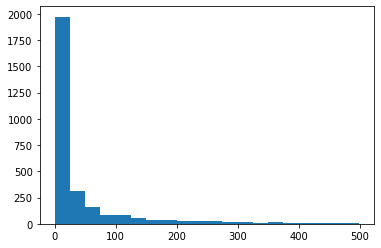

In [ ]:
plt.hist(affiliations_info[affiliations_info['weight'] < 500]['weight'], bins = 20)
plt.show()

In [ ]:
affiliations_info[affiliations_info['weight'] == affiliations_info['weight'].max()]

,AfId,DAfN,weight,In-degree,In-degree rank,PageRank,PageRank rank,Eigen,Eigen rank,Between,Between rank
2545,1.299303e+09,National Institutes of Health,3757.0,0.01559,1.0,0.012452,1.0,0.431182,1.0,0.017476,5.0


In [ ]:
affiliations_info[(affiliations_info['weight'] == affiliations_info[affiliations_info['weight'] != 3757]['weight'].max())]

,AfId,DAfN,weight,In-degree,In-degree rank,PageRank,PageRank rank,Eigen,Eigen rank,Between,Between rank
1268,115076166.0,UCL Institute of Neurology,3233.0,0.013416,2.0,0.011693,2.0,0.277956,4.0,0.017867,3.0


In [ ]:
affiliations_info[affiliations_info['weight'] >= 3000]

,AfId,DAfN,weight,In-degree,In-degree rank,PageRank,PageRank rank,Eigen,Eigen rank,Between,Between rank
6,2.417490e+05,University of Cambridge,3165.0,0.013134,3.0,0.010743,4.0,0.284237,3.0,0.022107,1.0
1268,1.150762e+08,UCL Institute of Neurology,3233.0,0.013416,2.0,0.011693,2.0,0.277956,4.0,0.017867,3.0
2545,1.299303e+09,National Institutes of Health,3757.0,0.015590,1.0,0.012452,1.0,0.431182,1.0,0.017476,5.0


### Connectivity components

In [ ]:
comp_df = pd.DataFrame()

In [ ]:
G = nx.read_weighted_edgelist(filenameInput,delimiter='\t')
components = nx.connected_components(G)

comp_df = pd.DataFrame()

i = 1
for comp in components:
    for aff in comp:
        comp_df.loc[aff, 'component'] = i
    i += 1
        
comp_df = comp_df.reset_index().rename(columns = {'index': 'AfId'})

comp_df.to_csv('aff_components.csv', sep = ';', index = False)

In [ ]:
comp_df

,AfId,component
0,202028630.0,1.0
1,153976015.0,1.0
2,21491767.0,1.0
3,6750721.0,1.0
4,201537933.0,1.0
...,...,...
3024,9073902.0,1.0
3025,31703152.0,2.0
3026,168416876.0,3.0
3027,180048034.0,4.0


In [ ]:
aff_net[aff_net['AfId1'] == 31703152]

,AfId1,AfId2,Y,weight
25077,31703152.0,31703152.0,2021,1


In [ ]:
aff_data[aff_data['AfId'] == 31703152]

,Id,AA,Year,AfId,DAfN
32919,2608933249,"[{'DAuN': 'Jéssica Paola Alcázar Arzuza', 'AuN...",2017,31703152.0,Universidad del Tolima
33949,2979125025,"[{'DAuN': 'P.A. Caro Aponte', 'AuN': 'p a caro...",2021,31703152.0,Universidad del Tolima


In [ ]:
aff_net[aff_net['AfId1'] == 168416876]

,AfId1,AfId2,Y,weight
114618,168416876.0,168416876.0,2018,1


In [ ]:
aff_data[aff_data['AfId'] == 168416876]

,Id,AA,Year,AfId,DAfN
3674,2750892474,"[{'DAuN': 'Breann T Colter', 'AuN': 'breann t ...",2017,168416876.0,Northern Kentucky University
14509,2758358450,"[{'DAuN': 'Kelsey Klinefelter', 'AuN': 'kelsey...",2018,168416876.0,Northern Kentucky University


In [ ]:
aff_net[aff_net['AfId1'] == 180048034]

,AfId1,AfId2,Y,weight
121472,180048034.0,180048034.0,2019,1


In [ ]:
aff_data[aff_data['AfId'] == 180048034]

,Id,AA,Year,AfId,DAfN
17088,2965153152,"[{'DAuN': 'Seisuke Mimori', 'AuN': 'seisuke mi...",2019,180048034.0,Chiba Institute of Science
25391,2067615369,"[{'DAuN': 'Seisuke Mimori', 'AuN': 'seisuke mi...",2015,180048034.0,Chiba Institute of Science


In [ ]:
aff_net[aff_net['AfId1'] == 878213199]

,AfId1,AfId2,Y,weight
148937,878213199.0,878213199.0,2019,1


In [ ]:
aff_data[aff_data['AfId'] == 878213199]

,Id,AA,Year,AfId,DAfN
29355,2033804088,"[{'DAuN': 'Vishal P. Zambre', 'AuN': 'vishal p...",2015,878213199.0,Savitribai Phule Pune University
31741,2959557482,"[{'DAuN': 'Vishal P. Zambre', 'AuN': 'vishal p...",2019,878213199.0,Savitribai Phule Pune University


## Centrality analysis

In [ ]:
net = pd.read_csv('drive/MyDrive/aff_net.csv', sep = ';')
net_no_periods = pd.read_csv('drive/MyDrive/aff_net_no_periods.csv', sep = '\t', names = ['AfId1', 'AfId2', 'weight'], header = None)

In [ ]:
affiliations_info = pd.read_csv('drive/MyDrive/affiliations_info.csv', sep = ';')

In [ ]:
affiliations_info.sort_values('TI, q=10% rank')

,AfId,DAfN,In-degree,In-degree rank,"BI, q=0.5%, s=3",BI 0.5% rank,"BI, q=1%, s=3",BI 1% rank,"BI, q=3%, s=3",BI 3% rank,...,"TI, q=5% rank","TI, q=10% rank","TI, q=0.1% rank",weight,PageRank,PageRank rank,Eigen,Eigen rank,Between,Between rank
2545,1.299303e+09,National Institutes of Health,0.015590,1.0,0.015815,3.0,0.011332,1.0,0.007949,4.0,...,2.0,1.0,2.0,3757.0,0.012452,1.0,4.311821e-01,1.0,0.017476,5.0
6,2.417490e+05,University of Cambridge,0.013134,3.0,0.014164,6.0,0.007027,9.0,0.006882,5.0,...,5.0,2.0,3.0,3165.0,0.010743,4.0,2.842373e-01,3.0,0.022107,1.0
464,4.012015e+07,University of Oxford,0.012171,4.0,0.013370,7.0,0.008404,3.0,0.006483,8.0,...,6.0,3.0,6.0,2933.0,0.011406,3.0,2.864604e-01,2.0,0.019079,2.0
2044,1.835194e+08,Capital Medical University,0.007793,12.0,0.010563,18.0,0.006820,12.0,0.005205,11.0,...,9.0,4.0,9.0,1878.0,0.005851,17.0,1.029324e-01,17.0,0.015036,9.0
882,7.957695e+07,University of Pennsylvania,0.008490,8.0,0.011185,15.0,0.006776,14.0,0.004642,17.0,...,10.0,5.0,8.0,2046.0,0.007605,8.0,1.582215e-01,7.0,0.009459,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,1.575566e+08,Institute of Science and Technology Austria,0.000000,418.0,0.000000,410.0,0.000000,556.0,0.000000,831.0,...,1151.0,1182.0,1044.0,0.0,0.000041,2534.0,1.823916e-16,2504.0,0.000000,2240.0
1755,1.579440e+08,Holon Institute of Technology,0.000000,418.0,0.000000,410.0,0.000000,556.0,0.000000,831.0,...,1151.0,1182.0,1044.0,0.0,0.000041,2534.0,1.823916e-16,2504.0,0.000000,2240.0
1756,1.580481e+08,Kinjo Gakuin University,0.000000,418.0,0.000000,410.0,0.000000,556.0,0.000000,831.0,...,1151.0,1182.0,1044.0,0.0,0.000041,2534.0,1.823916e-16,2504.0,0.000000,2240.0
1700,1.539017e+08,University of North Carolina at Wilmington,0.000000,418.0,0.000000,410.0,0.000000,556.0,0.000000,831.0,...,1151.0,1182.0,1044.0,0.0,0.000041,2534.0,1.823916e-16,2504.0,0.000000,2240.0


In [ ]:
net

,AfId1,AfId2,Y,weight
0,4.605000e+03,1.380062e+08,2017,1
1,9.507000e+03,9.507000e+03,2021,1
2,9.507000e+03,3.592860e+07,2021,2
3,9.507000e+03,4.012015e+07,2021,1
4,9.507000e+03,1.776393e+08,2021,1
...,...,...,...,...
170335,3.148998e+09,1.839358e+08,2021,1
170336,3.148998e+09,1.869036e+08,2021,2
170337,3.148998e+09,8.638962e+08,2021,1
170338,3.148998e+09,1.299303e+09,2021,2


In [ ]:
# self-citation

self_citation = net_no_periods[net_no_periods['AfId1'] == net_no_periods['AfId2']].merge(affiliations_info[['AfId', 'DAfN']], how = 'left', left_on = 'AfId1', right_on = 'AfId')[['AfId', 'DAfN', 'weight']].rename(columns = {'weight':'self_citations'})

In [ ]:
self_citation

,AfId,DAfN,self_citations
0,9.507000e+03,Sangji University,1
1,2.159270e+05,University of Madras,2
2,2.417490e+05,University of Cambridge,396
3,2.809150e+05,Miami Project to Cure Paralysis,1
4,2.809940e+05,King George's Medical University,3
...,...,...,...
1289,3.123573e+09,Transilvania University of Brașov,1
1290,3.124150e+09,San Sebastián University,1
1291,3.125471e+09,Istanbul Medipol University,3
1292,3.125582e+09,University of Fortaleza,1


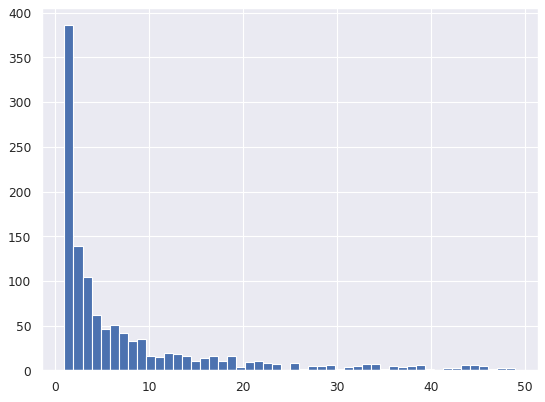

In [ ]:
import seaborn as sns
sns.set()
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(self_citation[self_citation['self_citations'] < 50]['self_citations'], bins = 50)
plt.show()

In [ ]:
cnt_citations = self_citation.groupby('self_citations').count()['AfId'].reset_index().rename(columns = {'AfId':'cnt'})

In [ ]:
cnt_citations.head(20)

,self_citations,cnt
0,1,386
1,2,139
2,3,104
3,4,62
4,5,46
5,6,51
6,7,42
7,8,33
8,9,35
9,10,16


In [ ]:
cnt_citations.tail(20)

,self_citations,cnt
101,153,2
102,158,1
103,164,1
104,172,1
105,173,1
106,177,1
107,178,1
108,190,1
109,192,1
110,198,1


In [ ]:
cnt_citations[cnt_citations['cnt'] > 3]

,self_citations,cnt
0,1,386
1,2,139
2,3,104
3,4,62
4,5,46
5,6,51
6,7,42
7,8,33
8,9,35
9,10,16


In [ ]:
affiliations_info = affiliations_info.merge(self_citation, how = 'left', on = ['AfId', 'DAfN'])
affiliations_info['self_citations'].fillna(0, inplace = True)
affiliations_info.loc[:, 'self_citations_proportion'] = affiliations_info['self_citations'] / affiliations_info['weight']

In [ ]:
affiliations_info

,AfId,DAfN,In-degree,In-degree rank,"BI, q=0.5%, s=3",BI 0.5% rank,"BI, q=1%, s=3",BI 1% rank,"BI, q=3%, s=3",BI 3% rank,...,"TI, q=10% rank","TI, q=0.1% rank",weight,PageRank,PageRank rank,Eigen,Eigen rank,Between,Between rank,self_citations
0,4.605000e+03,Illinois College of Optometry,0.000000,418.0,0.000000e+00,410.0,0.000000e+00,556.0,0.000000e+00,831.0,...,1182.0,1044.0,0.0,0.000041,2534.0,1.823916e-16,2504.0,0.000000e+00,2240.0,0.0
1,9.507000e+03,Sangji University,0.000004,417.0,1.016777e-09,409.0,2.668252e-09,555.0,2.478561e-08,830.0,...,1181.0,1043.0,1.0,0.000062,1783.0,5.836532e-15,2501.0,0.000000e+00,2240.0,1.0
2,5.232500e+04,Oswaldo Cruz Foundation,0.000062,403.0,5.846467e-07,395.0,1.534245e-06,541.0,1.425173e-05,813.0,...,1063.0,972.0,15.0,0.000081,1512.0,1.644998e-04,1635.0,5.670368e-05,928.0,0.0
3,8.004300e+04,Curie Institute,0.000033,410.0,9.354348e-08,402.0,2.454791e-07,548.0,2.280277e-06,823.0,...,1150.0,1017.0,8.0,0.000072,1633.0,5.668992e-04,1194.0,1.758805e-08,2204.0,0.0
4,1.899910e+05,University of Veterinary Medicine Hanover,0.000004,417.0,1.016777e-09,409.0,2.668252e-09,555.0,2.478561e-08,830.0,...,1181.0,1043.0,1.0,0.000043,2483.0,1.588128e-06,2398.0,2.018437e-07,2009.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,3.132422e+09,Shubun University,0.000021,413.0,2.541942e-08,405.0,6.670629e-08,551.0,6.196404e-07,826.0,...,1168.0,1030.0,5.0,0.000071,1640.0,5.424191e-05,1952.0,7.021884e-07,1834.0,0.0
3025,3.132940e+09,Politecnica Salesiana University,0.000025,412.0,2.541942e-08,405.0,6.670629e-08,551.0,6.196404e-07,826.0,...,1165.0,1027.0,6.0,0.000074,1600.0,1.454519e-05,2194.0,4.821735e-06,1440.0,0.0
3026,3.133171e+09,Bandırma Onyedi Eylül University,0.000008,416.0,3.050331e-09,408.0,8.004755e-09,554.0,7.435684e-08,829.0,...,1179.0,1041.0,2.0,0.000048,2187.0,6.368605e-06,2286.0,6.001509e-06,1389.0,0.0
3027,3.141574e+09,Department of Biotechnology,0.000133,386.0,3.358414e-06,383.0,8.813235e-06,529.0,8.186689e-05,779.0,...,567.0,834.0,32.0,0.000151,1020.0,4.987173e-04,1255.0,2.204478e-04,683.0,1.0


In [ ]:
columns = ['AfId', 'DAfN', 'In-degree', 'In-degree rank', 'weight', 'self_citations', 'self_citations_proportion', 'TI, q=0.1% rank', 'TI, q=1% rank', 'TI, q=3% rank', 'TI, q=5% rank', 'TI, q=10% rank']

In [ ]:
affiliations_info[columns].sort_values('weight', ascending = False).head(20)

,AfId,DAfN,In-degree,In-degree rank,weight,self_citations,self_citations_proportion,"TI, q=0.1% rank","TI, q=1% rank","TI, q=3% rank","TI, q=5% rank","TI, q=10% rank"
2545,1.299303e+09,National Institutes of Health,0.015590,1.0,3757.0,419.0,0.111525,2.0,1.0,3.0,2.0,1.0
1268,1.150762e+08,UCL Institute of Neurology,0.013416,2.0,3233.0,198.0,0.061243,1.0,2.0,1.0,1.0,42.0
6,2.417490e+05,University of Cambridge,0.013134,3.0,3165.0,396.0,0.125118,3.0,5.0,4.0,5.0,2.0
464,4.012015e+07,University of Oxford,0.012171,4.0,2933.0,359.0,0.122400,6.0,4.0,6.0,6.0,3.0
516,4.512925e+07,University College London,0.011959,5.0,2882.0,153.0,0.053088,4.0,6.0,2.0,3.0,47.0
1228,1.119799e+08,Northwestern University,0.011449,6.0,2759.0,207.0,0.075027,7.0,3.0,5.0,7.0,49.0
1520,1.362000e+08,Harvard University,0.010013,7.0,2413.0,149.0,0.061749,5.0,7.0,8.0,8.0,54.0
882,7.957695e+07,University of Pennsylvania,0.008490,8.0,2046.0,204.0,0.099707,8.0,8.0,11.0,10.0,5.0
1101,9.946410e+07,Katholieke Universiteit Leuven,0.007996,9.0,1927.0,206.0,0.106902,16.0,17.0,16.0,15.0,9.0
336,2.816691e+07,Karolinska Institutet,0.007855,10.0,1893.0,178.0,0.094031,10.0,12.0,12.0,11.0,39.0


In [ ]:
affiliations_info[columns].sort_values('self_citations', ascending = False).head(20)

,AfId,DAfN,In-degree,In-degree rank,weight,self_citations,self_citations_proportion,"TI, q=0.1% rank","TI, q=1% rank","TI, q=3% rank","TI, q=5% rank","TI, q=10% rank"
2545,1.299303e+09,National Institutes of Health,0.015590,1.0,3757.0,419.0,0.111525,2.0,1.0,3.0,2.0,1.0
6,2.417490e+05,University of Cambridge,0.013134,3.0,3165.0,396.0,0.125118,3.0,5.0,4.0,5.0,2.0
464,4.012015e+07,University of Oxford,0.012171,4.0,2933.0,359.0,0.122400,6.0,4.0,6.0,6.0,3.0
950,8.488419e+07,Newcastle University,0.007063,16.0,1702.0,250.0,0.146886,18.0,24.0,13.0,18.0,10.0
2088,1.875316e+08,Lund University,0.007440,15.0,1793.0,245.0,0.136642,19.0,20.0,19.0,19.0,11.0
1612,1.458724e+08,Radboud University Nijmegen,0.007465,14.0,1799.0,224.0,0.124514,12.0,19.0,14.0,13.0,6.0
2044,1.835194e+08,Capital Medical University,0.007793,12.0,1878.0,208.0,0.110756,9.0,10.0,10.0,9.0,4.0
1228,1.119799e+08,Northwestern University,0.011449,6.0,2759.0,207.0,0.075027,7.0,3.0,5.0,7.0,49.0
1101,9.946410e+07,Katholieke Universiteit Leuven,0.007996,9.0,1927.0,206.0,0.106902,16.0,17.0,16.0,15.0,9.0
882,7.957695e+07,University of Pennsylvania,0.008490,8.0,2046.0,204.0,0.099707,8.0,8.0,11.0,10.0,5.0


In [ ]:
affiliations_info[affiliations_info['weight'] > 1][columns].sort_values('self_citations_proportion', ascending = False).head(20)

,AfId,DAfN,In-degree,In-degree rank,weight,self_citations,self_citations_proportion,"TI, q=0.1% rank","TI, q=1% rank","TI, q=3% rank","TI, q=5% rank","TI, q=10% rank"
2169,1.953731e+08,Honam University,0.000008,416.0,2.0,2.0,1.000000,1042.0,1050.0,1103.0,1149.0,1180.0
1295,1.179799e+08,Rhodes College,0.000012,415.0,3.0,3.0,1.000000,1040.0,1048.0,1101.0,1147.0,1178.0
1395,1.259898e+08,Skolkovo Institute of Science and Technology,0.000008,416.0,2.0,2.0,1.000000,1042.0,1050.0,1103.0,1149.0,1180.0
513,4.485440e+07,University of Southern Mississippi,0.000008,416.0,2.0,2.0,1.000000,1042.0,1050.0,1103.0,1149.0,1180.0
395,3.358691e+07,Pandit Deendayal Petroleum University,0.000008,416.0,2.0,2.0,1.000000,1042.0,1050.0,1103.0,1149.0,1180.0
246,2.010792e+07,Sri Ramachandra University,0.000008,416.0,2.0,2.0,1.000000,1042.0,1050.0,1103.0,1149.0,1180.0
1326,1.194744e+08,Canterbury Christ Church University,0.000017,414.0,4.0,4.0,1.000000,1037.0,1045.0,1098.0,1144.0,1175.0
2193,1.975248e+08,Petrozavodsk State University,0.000041,408.0,10.0,9.0,0.900000,1010.0,1018.0,1071.0,1119.0,1154.0
290,2.435932e+07,Robert Koch Institute,0.000017,414.0,4.0,3.0,0.750000,1036.0,1044.0,1097.0,1143.0,1174.0
813,7.431921e+07,Chitkara University,0.000083,398.0,20.0,15.0,0.750000,941.0,949.0,1019.0,1075.0,1114.0


In [ ]:
affiliations_info[columns].sort_values('TI, q=10% rank').head(20)

,AfId,DAfN,In-degree,In-degree rank,weight,self_citations,self_citations_proportion,"TI, q=0.1% rank","TI, q=1% rank","TI, q=3% rank","TI, q=5% rank","TI, q=10% rank"
2545,1.299303e+09,National Institutes of Health,0.015590,1.0,3757.0,419.0,0.111525,2.0,1.0,3.0,2.0,1.0
6,2.417490e+05,University of Cambridge,0.013134,3.0,3165.0,396.0,0.125118,3.0,5.0,4.0,5.0,2.0
464,4.012015e+07,University of Oxford,0.012171,4.0,2933.0,359.0,0.122400,6.0,4.0,6.0,6.0,3.0
2044,1.835194e+08,Capital Medical University,0.007793,12.0,1878.0,208.0,0.110756,9.0,10.0,10.0,9.0,4.0
882,7.957695e+07,University of Pennsylvania,0.008490,8.0,2046.0,204.0,0.099707,8.0,8.0,11.0,10.0,5.0
1612,1.458724e+08,Radboud University Nijmegen,0.007465,14.0,1799.0,224.0,0.124514,12.0,19.0,14.0,13.0,6.0
2042,1.830679e+08,Shanghai Jiao Tong University,0.006959,18.0,1677.0,172.0,0.102564,14.0,25.0,18.0,14.0,7.0
391,3.321314e+07,University of Florida,0.006527,21.0,1573.0,192.0,0.122060,15.0,23.0,22.0,16.0,8.0
1101,9.946410e+07,Katholieke Universiteit Leuven,0.007996,9.0,1927.0,206.0,0.106902,16.0,17.0,16.0,15.0,9.0
950,8.488419e+07,Newcastle University,0.007063,16.0,1702.0,250.0,0.146886,18.0,24.0,13.0,18.0,10.0
